# Graph evaluation report
- Academic Year: 2019/20
- Faculty of Computing - Artificial Intelligence - Semester 2
- Full name and student id: Kacper Trębacz 145453
- Subject: Algorithms and Data Structures


This exercise consinst of two parts:
- evaluation different graph representations in terms of peformance when searching for an existance of an edge between 2 vertices
- determining best representation for topoligical order sorting and evaluate the time needed to perform it

In [1]:
from random import randint,sample, randrange
import sys
import matplotlib.pyplot as plt
import numpy as np
import time 
import math
import random
import string
import pandas as pd
import json
import os
import multiprocessing as mp
import psutil 
sys.setrecursionlimit(10**9)
import itertools
plt.rcParams['figure.figsize'] = (10.0, 6.0)

## Constants declaration

In [2]:

ADJACENCY_MATRIX = "Adjacency Matrix"
INCIDENCE_MATRIX = "Incidence Matrix"
EDGE_LIST = "Edge List"
LIST_OF_INCIDENTS = "List of Incidents"
TIMEOUT = 30
COPIES = 10

In [3]:
def edges_count(n,saturation):
    return int(n*(n-1)*saturation/2)

In [4]:
edge_saturations = [0.2, 0.3, 0.4, 0.6, 0.8, 0.95]

# Part 1

Firstly, we generate graphs with saturation factor 0.6 and save them to text files. There are 21 graphs of size from 2 to 2002 and 21 graphs of size from 2 to 202

In [5]:
def generate_connected_graph(n,saturation):
    array = np.zeros((n,n), dtype=bool)
    n_edges = edges_count(n,saturation)
    connected_edges = [randrange(0,n)]
    not_connected_edges = [i for i in range(n) if i not in connected_edges]
    random.shuffle(not_connected_edges)
    for i in range(n-1):
        not_connected = not_connected_edges.pop()
        connected = random.choice(connected_edges)
        array[not_connected][connected]=True
        array[connected][not_connected]=True
        connected_edges.append(not_connected)
    for i in range(n_edges-n+1):
        x,y = randrange(n), randrange(n)
        while x==y or array[x][y]:
            x,y = randrange(n), randrange(n)
        array[x][y] = True
        array[y][x] = True
    return array

def is_connected_ref(node_id, graph, n, visited):
    visited[node_id] = True
    if sum(visited) == len(visited):
        return True
    for i in range(n):
        if graph[node_id][i] and not visited[i]:
            if is_connected_ref(i,graph,n,visited):
                return True
    return False

def is_connected(graph,n):
    visited = [False]*n
    return is_connected_ref(0,graph, n,visited)
    
    

def generate_eulerian(n, saturation):
    graph = generate_connected_graph(n, saturation)
#     print(graph)
    even_vertices =[]
    odd_vertices =[]
    for i in range(n):
        num_od_edges = np.dot(np.ones(n), graph[i])
        if num_od_edges % 2 == 0:
            even_vertices.append(i)
        else:
            odd_vertices.append(i)
    desired_num_edges = edges_count(n,saturation)
    cur_num_edges = desired_num_edges
    while len(odd_vertices):
#         print(odd_vertices)
        #deletion
        for vert1, vert2 in itertools.combinations(odd_vertices,2):
            if graph[vert1][vert2]:
                graph[vert1][vert2], graph[vert2][vert1] = False, False
                if is_connected(graph, n):
                    cur_num_edges-=1
#                     print("removing ",vert1,vert2)
                    odd_vertices.remove(vert1)
                    odd_vertices.remove(vert2)
                    break
                graph[vert1][vert2], graph[vert2][vert1] = True, True
                if len(odd_vertices) == 2:
#                     print("edge case")
                    edge = 0
                    while edge == vert1 or edge == vert2 or graph[edge][vert1] or graph[edge][vert2]:
                        edge+=1
#                     print(edge)
                    graph[edge][vert1],graph[edge][vert2],graph[vert1][edge],graph[vert2][edge] = True,True,True,True
                    odd_vertices.remove(vert1)
                    odd_vertices.remove(vert2)
                    break
    
        #addition         
        for vert1, vert2 in itertools.combinations(odd_vertices,2):
                if not graph[vert1][vert2]:
#                     print("adding ",vert1,vert2)
                    cur_num_edges+=1
                    graph[vert1][vert2],graph[vert2][vert1] = True,True
                    odd_vertices.remove(vert1)
                    odd_vertices.remove(vert2)
                    break
    
    print(cur_num_edges/desired_num_edges)
#     print(graph)
    return graph
        
            
        

def generate_eulerian_and_write_to_file(min,max,jump,saturations):
    for saturation in saturations:
        print(saturation)
        for i in range(min,max,jump):
                graph = generate_eulerian(i,saturation)
                os.makedirs("data/eulerian/"+str(saturation)+"/"+str(i), exist_ok=True)
                np.savetxt("data/eulerian/"+str(saturation)+"/"+str(i)+"/"+str(0)+".txt", graph, fmt="%5i")


def generate_random_connected_and_write_to_file(min,max,jump,saturations):
    for sat in saturations:
        print(sat)
        for i in range(min,max,jump):
            copy=0
            os.makedirs("data/hamiltonian/"+str(sat)+"/"+str(i), exist_ok= True)
            while(copy<COPIES):
                graph = generate_connected_graph(i,sat)
                np.savetxt("data/hamiltonian/"+str(sat)+"/"+str(i)+"/"+str(copy)+".txt", graph, fmt="%5i")
                copy+=1

In [6]:
# generate_random_connected_and_write_to_file(10,312,15,edge_saturations)

In [7]:
# generate_eulerian_and_write_to_file(10,301,10,edge_saturations)

In [8]:
# for i in range(100):
#     graph = generate_eulerian(40,0.6)
#     listed = convert_to_list_of_incidents(40,graph)
#     print(is_eulerian(listed,40))
#     find_eulerian_cycle(listed,40)

# Graph representations delaration

Here we delacre functions which convert graphs from text files to a given representation. We also define functions for each reporesentation that check if a given edge exists in graph.

### Adjacency Matrix

In [9]:
def convert_to_adjacency_matrix(n,array):
    return array

def find_edge_adjacency_matrix(array,v1,v2):
    return array[v1][v2]

### List of Incidents

In [10]:
def convert_to_list_of_incidents(n,array):
    incidents_list = []
    for i in range(n):
        incidents = []
        for j in range(n):
            if i !=j and array[i][j] == 1:
                incidents.append(j)
        incidents_list.append(incidents)
    return incidents_list

def find_edge_list_of_incidents(array, v1, v2):
    return v2 in array[v1]

In [11]:
def backtracking_hamiltonian(graph, n_vert, path, depth,startTime):
    if time.time()-startTime >= TIMEOUT:
            print("timeout")
            raise TimeoutError("timeout :(")
    if depth == n_vert:
        return graph[path[depth-1]][path[0]]
    for v in range(0,n_vert):
        if (v not in path) and graph[path[depth-1]][v]:
            path.append(v)
            if backtracking_hamiltonian(graph,n_vert,path,depth+1,startTime):
                return path
            path.pop()
    return False

def backtracking_hamiltonian_adjacency(graph, n_vert, path, depth,startTime):
    if time.time()-startTime >= TIMEOUT:
            print("timeout")
            raise TimeoutError("timeout :(")
    if depth == n_vert:
        return path[0] in graph[path[depth-1]]
    for v in graph[path[depth-1]]:
        if (v not in path):
            path.append(v)
            if backtracking_hamiltonian_adjacency(graph,n_vert,path,depth+1,startTime):
                return path
            path.pop()
    return False

def measure_single_hamiltonian(graph,n):
        try:
            adj_list = convert_to_list_of_incidents(n,graph)
            startTime = time.time()
            backtracking_hamiltonian_adjacency(adj_list,n,[0],1,startTime)
            return time.time()-startTime
        except TimeoutError:
                return TIMEOUT
def measure_time_hamiltonian(graph,n):
    pool = mp.Pool(psutil.cpu_count(logical = False))
    times = pool.starmap(measure_single_hamiltonian,[(graph,n) for i in range(10)])
    pool.terminate()
    return (sum(times)/n)
def read_graph(folder,saturation,n,copy):
    return np.loadtxt("data/"+str(folder)+"/"+str(saturation)+"/"+str(n)+"/"+str(copy)+".txt", dtype=bool)

def measure_times_hamiltonian(saturation,n):
    print("N: "+str(n))
    pool = mp.Pool(psutil.cpu_count(logical = False))
    times = pool.starmap(measure_single_hamiltonian,[(read_graph("hamiltonian",saturation,n,copy),n) for copy in range(COPIES)])
    pool.terminate()
    return sum(times)/COPIES

In [12]:
def plot_plot(X,Ys,labels,title):
    for i in range(len(Ys)):
        plt.plot(X,Ys[i],label=str(labels[i]))
    plt.legend()
    plt.xlabel('Number of Elements')
    plt.ylabel('Time (s)')
    plt.title(title)
    plt.show()
    plt.close()

def perform_test_single_entry(entry, X):
    print("Saturation: "+str(entry))
    return [measure_times_hamiltonian(entry,n) for n in X]

def perform_tests(entries,minimum=11,maximum=22,jump=1):
    X = [i for i in range(minimum,maximum, jump)]
    Ys = [perform_test_single_entry(entry,X) for entry in entries]
    plot_plot(X, Ys, entries, "Hamiltonian cycle search time")
    plt.yscale("log")
    plot_plot(X, Ys, entries, "Hamiltonian cycle search time log")

In [13]:
# perform_tests(edge_saturations,10,312,15)

In [14]:
def eulerian_backtracking(graph, n_vert,n_edges, path, depth):
    if depth == n_edges:
        final_edge_exists = path[0] in graph[path[depth-1]]
        if final_edge_exists:
            path.append(path[0])
        return final_edge_exists
    for v in graph[path[depth-1]]:
        graph[path[depth-1]].remove(v)
        graph[v].remove(path[depth-1])
        path.append(v)
        if eulerian_backtracking(graph, n_vert, n_edges, path, depth+1):
            return path
        path.pop()
        graph[path[depth-1]].append(v)
        graph[v].append(path[depth-1])
    return False

def is_eulerian(graph,n):
    for vlist in graph:
        if len(vlist)%2==1:
            return False
    return True


def find_eulerian_cycle(graph,n):
    m=0
    for vlist in graph:
        length = len(vlist)
        if length%2==1:
            print("Problem")
            return False
        m+=length
    m=int(m/2)
    return eulerian_backtracking(graph,n,m,[0],1)
    

In [15]:
def measure_eulerian_single(graph,n):
    adj_list = convert_to_list_of_incidents(n,graph)
    startTime = time.time()
    find_eulerian_cycle(adj_list,n)
    return time.time()-startTime

def measure_times_eulerian(saturation,n):
    print("N",n)
    time = measure_eulerian_single(read_graph("eulerian",saturation,n,0),n)
    return time

In [16]:
def perform_test_single_entry_eulerian(entry, X):
    print("Saturation: "+str(entry))
    return [measure_times_eulerian(entry,n) for n in X]

def perform_tests_eulerian(entries,minimum=11,maximum=22,jump=1):
    X = [i for i in range(minimum,maximum, jump)]
    Ys = [perform_test_single_entry_eulerian(entry,X) for entry in entries]
    plot_plot(X, Ys, entries, "Eulerian cycle search time")
    plt.yscale("log")
    plot_plot(X, Ys, entries, "Eulerian cycle search time log scale")

Saturation: 0.2
N 10
N 20
N 30
N 40
N 50
N 60
N 70
N 80
N 90
N 100
N 110
N 120
N 130
N 140
N 150
N 160
N 170
N 180
N 190
N 200
Saturation: 0.3
N 10
N 20
N 30
N 40
N 50
N 60
N 70
N 80
N 90
N 100
N 110
N 120
N 130
N 140
N 150
N 160
N 170
N 180
N 190
N 200
Saturation: 0.4
N 10
N 20
N 30
N 40
N 50
N 60
N 70
N 80
N 90
N 100
N 110
N 120
N 130
N 140
N 150
N 160
N 170
N 180
N 190
N 200
Saturation: 0.6
N 10
N 20
N 30
N 40
N 50
N 60
N 70
N 80
N 90
N 100
N 110
N 120
N 130
N 140
N 150
N 160
N 170
N 180
N 190
N 200
Saturation: 0.8
N 10
N 20
N 30
N 40
N 50
N 60
N 70
N 80
N 90
N 100
N 110
N 120
N 130
N 140
N 150
N 160
N 170
N 180
N 190
N 200
Saturation: 0.95
N 10
N 20
N 30
N 40
N 50
N 60
N 70
N 80
N 90
N 100
N 110
N 120
N 130
N 140
N 150
N 160
N 170
N 180
N 190
N 200


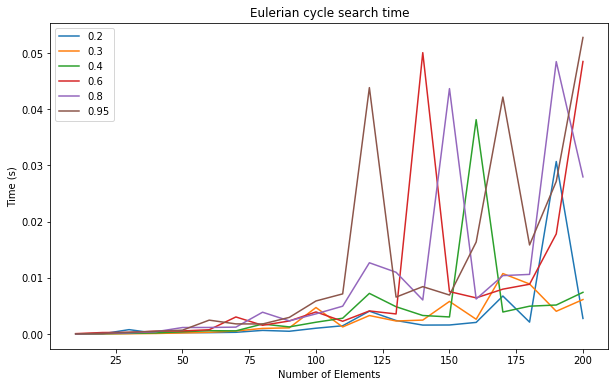

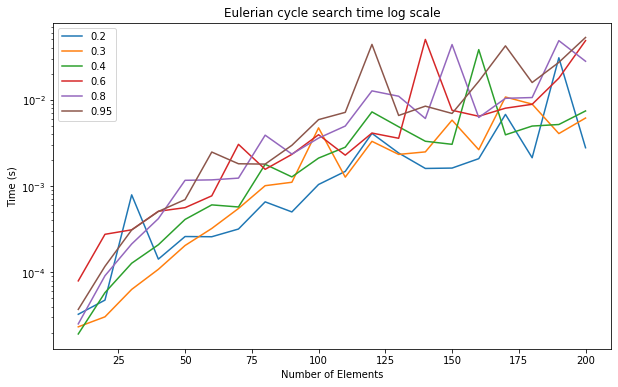

In [21]:
perform_tests_eulerian(edge_saturations,10,201,10)

In [18]:
# graph = np.array(
#     [[0,1,0,1,0,0],#0
#     [1,0,1,0,1,1],#1
#     [0,1,0,1,0,0],#2
#     [1,0,1,0,1,1],#3
#     [0,1,0,1,0,0],
#     [0,1,0,1,0,0]], dtype=bool)
# print(find_eulerian_cycle(graph,6,8))

In [19]:
nn = 270
graph = read_graph("eulerian",0.6,nn,0)
print("have graph")
listed = convert_to_list_of_incidents(nn, graph)
print("converted")
find_eulerian_cycle(listed,nn)


have graph
converted


[0,
 1,
 2,
 3,
 1,
 4,
 0,
 5,
 1,
 7,
 0,
 9,
 1,
 10,
 2,
 4,
 3,
 6,
 2,
 5,
 4,
 6,
 7,
 2,
 8,
 3,
 9,
 2,
 11,
 1,
 12,
 2,
 16,
 0,
 13,
 1,
 14,
 3,
 10,
 6,
 8,
 4,
 7,
 5,
 8,
 9,
 4,
 11,
 3,
 12,
 6,
 9,
 5,
 11,
 6,
 14,
 5,
 17,
 1,
 15,
 4,
 13,
 3,
 18,
 2,
 17,
 7,
 9,
 10,
 7,
 11,
 13,
 7,
 12,
 9,
 13,
 17,
 11,
 14,
 8,
 10,
 12,
 16,
 4,
 19,
 2,
 21,
 1,
 20,
 0,
 22,
 2,
 23,
 0,
 24,
 2,
 25,
 3,
 20,
 4,
 21,
 3,
 22,
 4,
 23,
 1,
 27,
 2,
 26,
 0,
 28,
 2,
 29,
 3,
 23,
 5,
 18,
 6,
 15,
 10,
 20,
 5,
 19,
 7,
 16,
 8,
 18,
 9,
 16,
 15,
 17,
 14,
 20,
 7,
 21,
 8,
 19,
 9,
 20,
 8,
 23,
 7,
 22,
 9,
 21,
 10,
 23,
 9,
 25,
 4,
 24,
 3,
 26,
 4,
 27,
 3,
 30,
 0,
 33,
 2,
 31,
 1,
 34,
 2,
 32,
 4,
 28,
 8,
 24,
 5,
 25,
 7,
 26,
 5,
 27,
 6,
 24,
 10,
 26,
 6,
 29,
 4,
 30,
 5,
 29,
 7,
 27,
 8,
 25,
 12,
 20,
 13,
 18,
 16,
 17,
 18,
 20,
 15,
 19,
 11,
 21,
 13,
 19,
 16,
 20,
 17,
 23,
 13,
 24,
 11,
 26,
 9,
 27,
 10,
 28,
 9,
 30,
 6,
 31,
 5,
 33,
 3,